# **Topic Modeling Using Gensim**


In [ ]:
!pip install stop-words
!pip install --upgrade  scikit-learn
!pip install pyLDAvis

## **Import The Libraries and Packages**

In [ ]:
import re
import numpy as np
import pandas as pd

from pprint import pprint
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=UserWarning)


In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import LdaModel

In [ ]:
# spacy for lemmatization
import spacy

In [ ]:
# Plotting tools
import pyLDAvis

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

In [ ]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [ ]:

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','also','may','define','accord','concept','including','within','see','well','way','usually','based','often'])

## **Import Dataset**

In [ ]:
#!pip install -U pandas-profiling

In [ ]:
df = pd.read_table("Statistics.txt",error_bad_lines=False)
df.head()

,text
0,statistics is the discipline that concerns the...
1,"today, statistics is widely employed in govern..."
2,sampling theory is part of the mathematical d...
3,a statistic is a random variable that is a fun...
4,a critical region is the set of values of the ...


In [ ]:
# Convert to list
data = df.text.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['statistics is the discipline that concerns the collection, organization, '
 'analysis, interpretation, and presentation of data. in applying statistics '
 'to a scientific, industrial, or social problem, it is conventional to begin '
 'with a statistical population or a statistical model to be studied. '
 'populations can be diverse groups of people or objects such as "all people '
 'living in a country" or "every atom composing a crystal". statistics deals '
 'with every aspect of data, including the planning of data collection in '
 'terms of the design of surveys and experiments. when census data cannot be '
 'collected, statisticians collect data by developing specific experiment '
 'designs and survey samples. representative sampling assures that inferences '
 'and conclusions can reasonably extend from the sample to the population as a '
 'whole. an experimental study involves taking measurements of the system '
 'under study, manipulating the system, and then taking additional

In [ ]:
# Convert to list
#df= df.values.tolist()

In [ ]:
#pprint(df[:1])

In [ ]:
#remove punctuations
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

df_words = list(sent_to_words(data))

print(df_words[:1])

[['statistics', 'is', 'the', 'discipline', 'that', 'concerns', 'the', 'collection', 'organization', 'analysis', 'interpretation', 'and', 'presentation', 'of', 'data', 'in', 'applying', 'statistics', 'to', 'scientific', 'industrial', 'or', 'social', 'problem', 'it', 'is', 'conventional', 'to', 'begin', 'with', 'statistical', 'population', 'or', 'statistical', 'model', 'to', 'be', 'studied', 'populations', 'can', 'be', 'diverse', 'groups', 'of', 'people', 'or', 'objects', 'such', 'as', 'all', 'people', 'living', 'in', 'country', 'or', 'every', 'atom', 'composing', 'crystal', 'statistics', 'deals', 'with', 'every', 'aspect', 'of', 'data', 'including', 'the', 'planning', 'of', 'data', 'collection', 'in', 'terms', 'of', 'the', 'design', 'of', 'surveys', 'and', 'experiments', 'when', 'census', 'data', 'cannot', 'be', 'collected', 'statisticians', 'collect', 'data', 'by', 'developing', 'specific', 'experiment', 'designs', 'and', 'survey', 'samples', 'representative', 'sampling', 'assures', 't

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  



In [ ]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



In [ ]:
# See trigram example
print(trigram_mod[bigram_mod[df_words[0]]])

['statistics', 'is', 'the', 'discipline', 'that', 'concerns', 'the', 'collection', 'organization', 'analysis', 'interpretation', 'and', 'presentation', 'of', 'data', 'in', 'applying', 'statistics', 'to', 'scientific', 'industrial', 'or', 'social', 'problem', 'it', 'is', 'conventional', 'to', 'begin', 'with', 'statistical', 'population', 'or', 'statistical', 'model', 'to', 'be', 'studied', 'populations', 'can', 'be', 'diverse', 'groups', 'of', 'people', 'or', 'objects', 'such', 'as', 'all', 'people', 'living', 'in', 'country', 'or', 'every', 'atom', 'composing', 'crystal', 'statistics', 'deals', 'with', 'every', 'aspect', 'of', 'data', 'including', 'the', 'planning', 'of', 'data', 'collection', 'in', 'terms', 'of', 'the', 'design', 'of', 'surveys', 'and', 'experiments', 'when', 'census', 'data', 'cannot', 'be', 'collected', 'statisticians', 'collect', 'data', 'by', 'developing', 'specific', 'experiment', 'designs', 'and', 'survey', 'samples', 'representative', 'sampling', 'assures', 'th

**Remove Stopwords, Make Bigrams and Lemmatize**

In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [ ]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [ ]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let’s call the functions in order.

In [ ]:
# Remove StopWords
df_words_nostops = remove_stopwords(df_words)

In [ ]:
# Form Bigrams
df_words_bigrams = make_bigrams(df_words_nostops)

In [ ]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])


In [ ]:
# Do lemmatization keeping only noun, adj, vb, adv
df_lemmatized = lemmatization(df_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
print(df_lemmatized[:1])

[['statistic', 'discipline', 'concern', 'datum', 'apply', 'statistic', 'scientific', 'industrial', 'social', 'problem', 'conventional', 'begin', 'statistical', 'population', 'statistical', 'model', 'study', 'population', 'diverse', 'group', 'people', 'object', 'people', 'live', 'country', 'atom', 'compose', 'statistic', 'deal', 'aspect', 'data', 'planning', 'datum', 'collection', 'term', 'design', 'survey', 'experiment', 'census', 'datum', 'can', 'collect', 'statistician', 'collect', 'datum', 'develop', 'specific', 'experiment', 'design', 'survey', 'sample', 'sampling', 'assure', 'inference', 'conclusion', 'reasonably', 'extend', 'sample', 'population', 'whole', 'experimental', 'study', 'involve', 'take', 'measurement', 'system', 'study', 'manipulating', 'system', 'take', 'additional', 'measurement', 'use', 'procedure', 'determine', 'manipulation', 'modify', 'value', 'measurement', 'contrast', 'observational', 'study', 'involve', 'experimental', 'manipulation', 'main', 'statistical', '

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(df_lemmatized)

# Create Corpus
texts = df_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 2), (11, 2), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 2), (18, 2), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 3), (40, 4), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 3), (48, 2), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 8), (62, 2), (63, 25), (64, 2), (65, 2), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 2), (72, 2), (73, 2), (74, 1), (75, 2), (76, 3), (77, 2), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 3), (84, 2), (85, 1), (86, 5), (87, 1), (88, 5), (89, 1), (90, 1), (91, 1), (92, 2), (93, 2), (94, 1), (95, 7), (96, 2), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 3), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 3), (110, 1

In [ ]:
id2word[0]

'account'

or see this also

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('account', 1),
  ('actual', 1),
  ('additional', 1),
  ('address', 1),
  ('adequate', 1),
  ('algebra', 1),
  ('analysis', 5),
  ('analyst', 1),
  ('answer', 1),
  ('application', 2),
  ('apply', 2),
  ('arab', 2),
  ('arabic', 1),
  ('aspect', 1),
  ('associate', 2),
  ('association', 1),
  ('assure', 1),
  ('atom', 2),
  ('back', 2),
  ('base', 1),
  ('basic', 1),
  ('begin', 1),
  ('bias', 2),
  ('bill', 1),
  ('blunder', 1),
  ('body', 1),
  ('book', 1),
  ('branch', 2),
  ('broaden', 1),
  ('call', 2),
  ('can', 1),
  ('categorical', 1),
  ('censor', 1),
  ('census', 2),
  ('central', 1),
  ('characteristic', 1),
  ('characterize', 2),
  ('choose', 1),
  ('classify', 1),
  ('collect', 3),
  ('collection', 4),
  ('combination', 1),
  ('come', 1),
  ('common', 1),
  ('compare', 1),
  ('compile', 1),
  ('compose', 2),
  ('concern', 3),
  ('conclusion', 2),
  ('consider', 1),
  ('contain', 2),
  ('context', 1),
  ('continuous', 1),
  ('contrast', 1),
  ('contribution', 1),
  ('conv

## **Wordcloud**

In [ ]:
text=str(data)

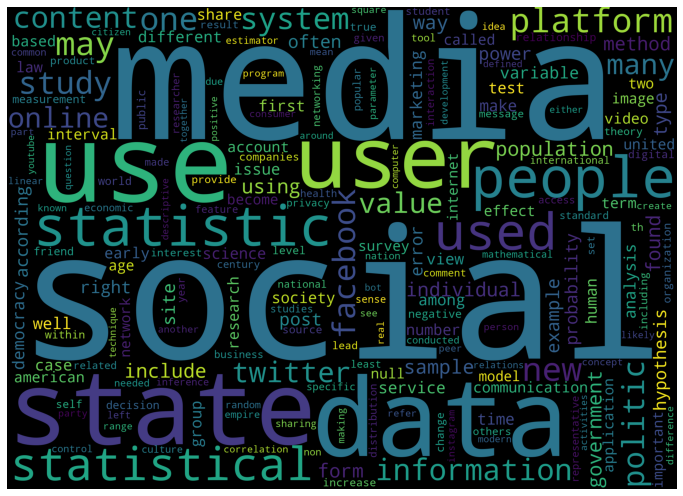

In [ ]:
# Generate wordcloud
stopwords = STOPWORDS
stopwords.add('will')
stopwords.add('political')
plt.figure(figsize=(12,12))
#text = description_category.description.values
cloud = WordCloud(stopwords=STOPWORDS, background_color='black', collocations=False, width=2500, height=1800).generate(text)
plt.axis('off')
plt.imshow(cloud)

## **LDA**

In [ ]:
ldamodel = LdaModel(corpus=corpus, num_topics=5, id2word=id2word)

In [ ]:
pprint(ldamodel.print_topics())
doc_lda = ldamodel[corpus]

[(0,
  '0.014*"medium" + 0.010*"social" + 0.009*"statistical" + 0.009*"political" + '
  '0.008*"statistic" + 0.007*"datum" + 0.006*"study" + 0.005*"use" + '
  '0.005*"sample" + 0.004*"people"'),
 (1,
  '0.037*"social" + 0.029*"medium" + 0.012*"political" + 0.008*"user" + '
  '0.008*"use" + 0.006*"platform" + 0.006*"people" + 0.005*"state" + '
  '0.005*"information" + 0.004*"datum"'),
 (2,
  '0.027*"social" + 0.022*"medium" + 0.011*"political" + 0.008*"use" + '
  '0.007*"people" + 0.007*"state" + 0.006*"datum" + 0.006*"user" + '
  '0.006*"study" + 0.004*"make"'),
 (3,
  '0.029*"medium" + 0.023*"social" + 0.009*"use" + 0.006*"user" + '
  '0.006*"statistical" + 0.006*"people" + 0.006*"datum" + 0.005*"statistic" + '
  '0.005*"study" + 0.004*"political"'),
 (4,
  '0.022*"social" + 0.018*"medium" + 0.012*"political" + 0.009*"use" + '
  '0.008*"system" + 0.005*"datum" + 0.005*"statistic" + 0.005*"user" + '
  '0.005*"politic" + 0.005*"study"')]


## **Topic Visualization**
From the model we created, lets look at the most salient terms under each topic that contributes to it the most

In [ ]:
from pandas.compat._optional import import_optional_dependency

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(ldamodel, corpus, id2word)

In [ ]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.022260  0.000386       1        1  61.651315
2     -0.004327 -0.005689       2        1  17.480591
0      0.023063 -0.000594       3        1  11.409448
4      0.002656 -0.004164       4        1   6.312576
3      0.000868  0.010060       5        1   3.146069, topic_info=           Term        Freq       Total Category  logprob  loglift
1058     medium  312.000000  312.000000  Default  30.0000  30.0000
231      social  386.000000  386.000000  Default  29.0000  29.0000
262         use   93.000000   93.000000  Default  28.0000  28.0000
189   political  136.000000  136.000000  Default  27.0000  27.0000
63        datum   63.000000   63.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
321        find    1.092789   40.223782   Topic5  -5.8802  -0.1467
1097       post    1.102063   45.846905   Topic5  -5.8717  -0.2691
189   political    1.631685  136.826463   Topic5  -5.4793  -0.9701
1117      share    0.979256   41.646120   Topic5  -5.9899  -0.2912
257        type    0.909613   29.694726   Topic5  -6.0637  -0.0267

[392 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2790      1  0.671487  absence
940       1  0.703412   access
940       2  0.150731   access
940       3  0.050244   access
940       4  0.050244   access
...     ...       ...      ...
270       4  0.109802     work
588       1  0.561445    would
588       2  0.280722    would
588       3  0.093574    would
588       4  0.093574    would

[691 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4])

## **Coherence Values**

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_lemmatized, start=1, limit=6, step=1)

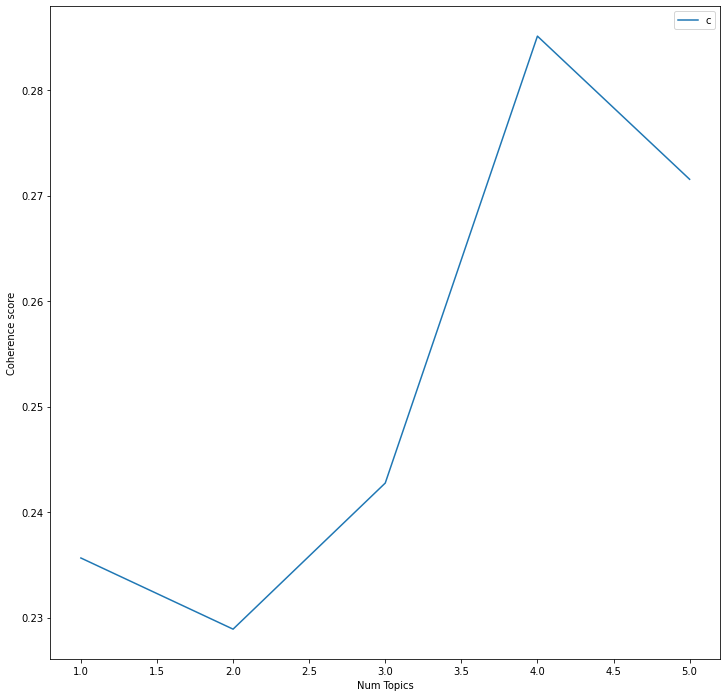

In [ ]:
limit=6; start=1; step=1;
x = range(start, limit, step)
plt.figure(figsize=(12,12))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 1  has Coherence Value of 0.2356
Num Topics = 2  has Coherence Value of 0.2289
Num Topics = 3  has Coherence Value of 0.2427
Num Topics = 4  has Coherence Value of 0.2851
Num Topics = 5  has Coherence Value of 0.2715


### **Prominant Topic**

In [ ]:
# Select the model and print the topics

optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.013*"social" + 0.013*"medium" + 0.010*"political" + 0.010*"statistic" + '
  '0.009*"statistical" + 0.009*"datum" + 0.008*"study" + 0.006*"use" + '
  '0.005*"population" + 0.005*"sample"'),
 (1,
  '0.030*"social" + 0.028*"medium" + 0.014*"political" + 0.011*"use" + '
  '0.008*"user" + 0.007*"state" + 0.006*"people" + 0.005*"platform" + '
  '0.005*"system" + 0.004*"make"'),
 (2,
  '0.034*"medium" + 0.027*"social" + 0.008*"user" + 0.008*"political" + '
  '0.007*"people" + 0.007*"use" + 0.005*"study" + 0.005*"information" + '
  '0.005*"platform" + 0.004*"find"'),
 (3,
  '0.034*"social" + 0.019*"medium" + 0.008*"datum" + 0.008*"use" + '
  '0.006*"political" + 0.006*"people" + 0.005*"user" + 0.005*"study" + '
  '0.005*"platform" + 0.004*"information"'),
 (4,
  '0.025*"social" + 0.017*"medium" + 0.009*"political" + 0.006*"use" + '
  '0.006*"people" + 0.005*"statistical" + 0.005*"statistic" + 0.005*"datum" + '
  '0.005*"state" + 0.004*"study"')]


# **Dataset**

In [ ]:
def format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
dataa= df_topic_sents_keywords.reset_index()
dataa.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
dataa

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9985,"social, medium, political, statistic, statisti...",statistics is the discipline that concerns the...
1,1,4.0,0.7031,"social, medium, political, use, people, statis...","today, statistics is widely employed in govern..."
2,2,0.0,0.9986,"social, medium, political, statistic, statisti...",sampling theory is part of the mathematical d...
3,3,4.0,0.8532,"social, medium, political, use, people, statis...",a statistic is a random variable that is a fun...
4,4,0.0,0.9956,"social, medium, political, statistic, statisti...",a critical region is the set of values of the ...
5,5,0.0,0.9965,"social, medium, political, statistic, statisti...",applied statistics comprises descriptive stat...
6,6,4.0,0.9951,"social, medium, political, use, people, statis...",statistics is also heavily used in management...
7,7,1.0,0.9988,"social, medium, political, use, user, state, p...",social media are interactive technologies that...
8,8,1.0,0.9996,"social, medium, political, use, user, state, p...",mobile social media are a useful application ...
9,9,2.0,0.8816,"medium, social, user, political, people, use, ...",scientists use social media to share their sc...


In [ ]:
#label Encoding
from sklearn.preprocessing import LabelEncoder
dataa['Dominant_Topic'] = LabelEncoder().fit_transform(dataa['Dominant_Topic'])

In [ ]:
#split the data into x and y
x= dataa['Text'].values
y=dataa['Dominant_Topic'].values

In [ ]:
y=dataa['Dominant_Topic']# dependent feature
y

0     3
1     0
2     3
3     3
4     0
5     0
6     3
7     2
8     2
9     2
10    2
11    2
12    1
13    1
14    2
15    1
16    2
17    1
18    3
Name: Dominant_Topic, dtype: int64

In [ ]:
#y.values.reshape(1,-1) 

array([[4.],
       [1.],
       [1.],
       [4.],
       [1.],
       [1.],
       [4.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [2.],
       [2.],
       [3.],
       [2.],
       [3.],
       [2.],
       [4.]])

In [ ]:
## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_v=TfidfVectorizer(max_features=5000,ngram_range=(1,3),lowercase=False)
X=tfidf_v.fit_transform(dataa['Text']).toarray()  #Independent feature

In [ ]:
#x=np.array(X).reshape(-1,1)

In [ ]:
#X=np.shape(X)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500,ngram_range=(1,1))
X = cv.fit_transform(x).toarray()

In [ ]:
#X.reshape(1,-1) 


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state =0)

In [ ]:
X_test

array([[0.        , 0.        , 0.01284456, ..., 0.02599024, 0.0039544 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01971337, 0.01971337, 0.0135207 , ..., 0.00547168, 0.02081278,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.02422754, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# **Model Building**

In [ ]:
!pip install --upgrade xgboost

In [ ]:
import xgboost
from xgboost import XGBClassifier

In [ ]:
!pip install --upgrade  scikit-learn

In [ ]:
!pip install --upgrade naive_bayes

### **Naive Bayes**

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

In [ ]:
# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred=classifier.predict(X_train)
print(confusion_matrix(y_train,y_pred))
print(accuracy_score(y_train,y_pred))
print(classification_report(y_train,y_pred))

[[4 0 0 0]
 [0 5 0 0]
 [0 0 1 0]
 [0 0 0 2]]
1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



In [ ]:
y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [0 4 0 0]
 [0 1 0 0]
 [2 0 0 0]]
0.5714285714285714
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.80      1.00      0.89         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.57         7
   macro avg       0.20      0.25      0.22         7
weighted avg       0.46      0.57      0.51         7



In [ ]:
import pickle
with open('nby_model','wb') as f:
  pickle.dump(classifier,f)

In [ ]:
classifier.fit(X, y)

GaussianNB()

In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X)

In [ ]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
cm = confusion_matrix(y, y_pred)
acc=accuracy_score(y, y_pred)
acc


1.0

### **Random Forest**

In [ ]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_features"     : [ 0, 1, 3, 5, 6, 7, 8 ],
 "n_estimators"     : [ 10,15,20,30,50,100],
 " min_samples_leaf" : [3,4,5,6,7,8 ]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
classifier=RandomForestClassifier()
gd=GridSearchCV(classifier,param_grid=params,n_jobs=-1)

In [ ]:
gd.estimator

RandomForestClassifier()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier=RandomForestClassifier(n_estimators=900,max_features=6,min_samples_leaf=6,min_samples_split=5,n_jobs=-1)
classifier.fit(X_train,y_train)

RandomForestClassifier(max_features=6, min_samples_leaf=6, min_samples_split=5,
                       n_estimators=900, n_jobs=-1)

In [ ]:
y_pred=classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4 0 0]
 [1 0 0]
 [2 0 0]]
0.5714285714285714
              precision    recall  f1-score   support

           1       0.57      1.00      0.73         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.57         7
   macro avg       0.19      0.33      0.24         7
weighted avg       0.33      0.57      0.42         7



### **XGBoost**

In [ ]:
import xgboost 
from xgboost import XGBClassifier
clf =XGBClassifier(n_estimators =800,max_depth=3,n_jobs=-1)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[11:12:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[0 0 0 0]
 [1 3 0 0]
 [1 0 0 0]
 [0 2 0 0]]
0.42857142857142855
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.60      0.75      0.67         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.43         7
   macro avg       0.15      0.19      0.17         7
weighted avg       0.34      0.43      0.38         7



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [ ]:
classifier=xgboost.XGBClassifier()
random_search=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring='auccuracy',n_jobs=-1,refit=True,cv=10,verbose=3)

In [ ]:
random_search.estimator

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

In [ ]:
s=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=True,
              validate_parameters=None, verbosity=None)
s.fit(X_train,y_train)

[11:07:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred=s.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [1 3 0 0]
 [1 0 0 0]
 [0 2 0 0]]
0.42857142857142855
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.60      0.75      0.67         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.43         7
   macro avg       0.15      0.19      0.17         7
weighted avg       0.34      0.43      0.38         7



In [ ]:
import pickle
with open('gbb_final','wb') as f:
  pickle.dump(classifier,f)

### **Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf_gr = GradientBoostingClassifier()
clf_gr.fit(X_train, y_train)

GradientBoostingClassifier()

In [ ]:
y_pred=clf_gr.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [0 3 0 1]
 [0 1 0 0]
 [2 0 0 0]]
0.42857142857142855
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.75      0.75      0.75         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.43         7
   macro avg       0.19      0.19      0.19         7
weighted avg       0.43      0.43      0.43         7



In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train,y_train)

MultinomialNB()

In [ ]:
y_pred=clf.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [0 3 1 0]
 [0 0 1 0]
 [2 0 0 0]]
0.5714285714285714
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.86         4
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         2

    accuracy                           0.57         7
   macro avg       0.38      0.44      0.38         7
weighted avg       0.64      0.57      0.59         7



### **AdaBoost**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
num_trees = 1000
seed=7
kfold = KFold(n_splits=10, random_state=None)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=None)
model.fit(X_train,y_train)

AdaBoostClassifier(n_estimators=1000)

In [ ]:
y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[4 0 0]
 [0 1 0]
 [2 0 0]]
0.7142857142857143
              precision    recall  f1-score   support

           1       0.67      1.00      0.80         4
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.71         7
   macro avg       0.56      0.67      0.60         7
weighted avg       0.52      0.71      0.60         7



### **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_classifier=KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn_classifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [2 2 0 0]
 [0 1 0 0]
 [2 0 0 0]]
0.2857142857142857
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      0.50      0.57         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.29         7
   macro avg       0.17      0.12      0.14         7
weighted avg       0.38      0.29      0.33         7



### **Decision Tree**

In [ ]:
#Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
model= DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred=model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [1 2 0 1]
 [1 0 0 0]
 [0 2 0 0]]
0.2857142857142857
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.50      0.50         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.29         7
   macro avg       0.12      0.12      0.12         7
weighted avg       0.29      0.29      0.29         7



### **BaggingClassifier**

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
seed = 7
kfold = KFold(n_splits=10, random_state=seed,shuffle=True)
cart = DecisionTreeClassifier()
num_trees = 1000

model1 = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
model1.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=1000,
                  random_state=7)

In [ ]:
y_pred=model1.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[0 0 0 0]
 [0 4 0 0]
 [0 1 0 0]
 [1 1 0 0]]
0.5714285714285714
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.67      1.00      0.80         4
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2

    accuracy                           0.57         7
   macro avg       0.17      0.25      0.20         7
weighted avg       0.38      0.57      0.46         7



### **SVM**

In [ ]:
from sklearn import svm

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
clff = SVC(probability=True)
clff.fit(X_train,y_train)


SVC(probability=True)

In [ ]:
y_pred=clff.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3 1 0]
 [0 1 0]
 [2 0 0]]
0.5714285714285714
              precision    recall  f1-score   support

           1       0.60      0.75      0.67         4
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         2

    accuracy                           0.57         7
   macro avg       0.37      0.58      0.44         7
weighted avg       0.41      0.57      0.48         7



## **Save The Model**

In [ ]:
import pickle
with open('svm_final','wb') as f:
  pickle.dump(clff,f)